In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from matplotlib import colors

In [2]:
# NeurIPS
textwidth = 5.5

figsizes = {
    "full_width_golden_ratio": (textwidth, textwidth / 1.618),
    "full_width_small": (textwidth, textwidth / 2 / 1.618),
    "half_width_golden_ratio": (textwidth / 2, textwidth / 2 / 1.618),
    "half_width_square": (textwidth / 2, textwidth / 2),
}

# Define font for Latex PDF
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}",
        "font.family": "ptmr8t",
    }
)

# Plot Synthetic results

In [3]:
df = pd.read_csv("./results/synthetic.csv")

df["experiment"] = df[["k_compare", "method_family", "adjustment", "random_model_true",
                       "random_model_pred"]].apply(lambda x: hash(f"{x[0]}-{x[1]}-{x[2]}-{x[3]}-{x[4]}"), axis=1)
df["trial"] = df.groupby("experiment").cumcount()
del df["experiment"]
df

/tmp/ipykernel_2965/159172196.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "random_model_pred"]].apply(lambda x: hash(f"{x[0]}-{x[1]}-{x[2]}-{x[3]}-{x[4]}"), axis=1)


,value,confidence_low,confidence_high,n,k_reference,k_compare,method_family,adjustment,random_model_true,random_model_pred,trial
0,0.499230,0.499230,0.499230,500,10,2,RI,NORMALIZED,PERM,PERM,0
1,-0.001678,-0.001678,-0.001678,500,10,2,RI,ADJUSTED,PERM,PERM,0
2,1.024108,1.024108,1.024108,500,10,2,RI,STANDARDIZED,PERM,PERM,0
3,0.003770,0.003770,0.003770,500,10,2,MI,NORMALIZED,PERM,PERM,0
4,0.499928,0.499928,0.499928,500,10,2,RI,NORMALIZED,NUM,NUM,0
...,...,...,...,...,...,...,...,...,...,...,...
179995,-0.835414,-0.862820,-0.804779,500,10,14,MI,STANDARDIZED,NUM,NUM,999
179996,-2.646816,-2.699904,-2.588429,500,10,18,MI,STANDARDIZED,NUM,NUM,999
179997,-0.000293,-0.000531,-0.000068,500,10,18,MI,ADJUSTED,NUM,NUM,999
179998,-0.003652,-0.003886,-0.003407,500,10,22,MI,ADJUSTED,NUM,NUM,999


In [4]:
#df = pd.read_csv("./results/synthetic.csv")

n_trials = df["trial"].nunique()

# Assemble metric names for plotting
df["one_sided"] = (df["random_model_true"] == "PERM") & (
    df["random_model_true"] != df["random_model_pred"])
df["metric_name"] = df.apply(lambda x: f"{'' if ((x['method_family'] == 'RI') and (x['adjustment'] == 'NORMALIZED')) or (
    x['adjustment'] == 'NONE') else x['adjustment'][0]}{x['method_family']}$_\\text{{{x['random_model_pred'].lower()}}}{'^1' if x['one_sided'] else ''}$", axis=1)

# Filter only the highest value for each metric and number of clusters and trial
df = df.sort_values("value", ascending=False).drop_duplicates(
    ["metric_name", "trial"], keep="first"
)

metric_name_mapping = df[['method_family', 'adjustment', 'random_model_pred', 'one_sided', 'metric_name']].drop_duplicates().to_records(index=False)
metric_name_mapping = {(m[0], m[1], m[2], m[3]): m[4] for m in metric_name_mapping}
for method_family in df['method_family'].unique():
    for adjustment in df['adjustment'].unique():
        for one_sided in [True, False]:
            if (method_family, adjustment, 'PERM', one_sided) not in metric_name_mapping:
                metric_name_mapping[(method_family, adjustment, 'PERM', one_sided)] = metric_name_mapping[(method_family, adjustment, 'PERM', not one_sided)]

data = df.groupby(["metric_name", "k_compare"]
                  ).size().unstack().fillna(0).div(n_trials)

## Gridded Plot

In [5]:
method_family = "RI"
one_sided = True

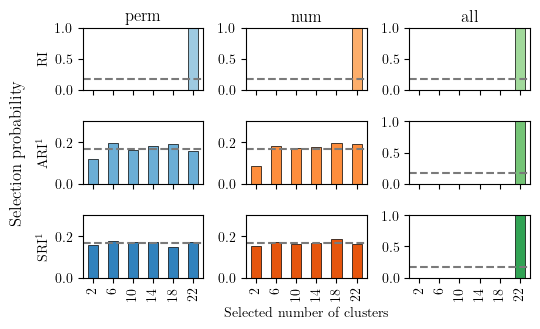

In [6]:
# Plot a grid of bar plots
adjustment_types = ["NORMALIZED", "ADJUSTED", "STANDARDIZED"]
random_models = ["PERM", "NUM", "ALL"]

# Get the tab20c colormap
tab20c = plt.get_cmap("tab20c")

fig, axes = plt.subplots(
    figsize=figsizes["full_width_golden_ratio"], ncols=3, nrows=3, sharex=True, sharey=False)

for i, (axes_row, adjustment_type) in enumerate(zip(axes, adjustment_types)):
    for j, (ax, random_model) in enumerate(zip(axes_row, random_models)):
        metric_name = metric_name_mapping[(method_family, adjustment_type, random_model, one_sided)]
        probabilities = data.loc[metric_name]
        probabilities.plot.bar(
            ax=ax, color=tab20c.colors[4*j+(2-i)], edgecolor="black", linewidth=0.5)
        if probabilities.max() > 0.5:
            ax.set_ylim(0, 1)
        else:
            ax.set_ylim(0, 0.3)
        # Plot horizontal line
        ax.axhline(1 / len(probabilities), color="#7a7a7a", linestyle="dashed")

pad = 5
for ax, col in zip(axes[0], random_models):
    ax.annotate(
        col.lower(),
        xy=(0.5, 1),
        xytext=(0, pad),
        xycoords="axes fraction",
        textcoords="offset points",
        size="large",
        ha="center",
        va="baseline",
    )

for ax, row in zip(axes[:, 0], adjustment_types):
    label = f"{method_family}"
    if not ((row == "NORMALIZED") and (method_family == "RI")):
        label = f"{row[0]}{label}"
    if (row != "NORMALIZED") and one_sided:
        label = label + "$^1$"
    ax.set_ylabel(
        label,
    )

ax = axes[1, 0]
ax.annotate(
    f"Selection probability",
    xy=(0, 0.5),
    xytext=(-ax.yaxis.labelpad - pad, 0),
    xycoords=ax.yaxis.label,
    textcoords="offset points",
    size="large",
    ha="right",
    va="center",
    rotation=90,
)

axes[2, 0].set_xlabel(None)
axes[2, 1].set_xlabel("Selected number of clusters")
axes[2, 2].set_xlabel(None)

fig.tight_layout(h_pad=-0.75)
suffix = "_one_sided" if one_sided else ""
fig.savefig(f"./results/synthetic_{method_family}{suffix}.pdf")

## One vs Two-sided

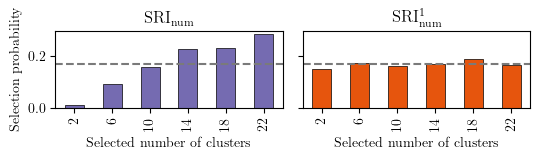

In [7]:
fig, axes = plt.subplots(
    1, 2, figsize=figsizes["full_width_small"], sharey=True)

tab20c = plt.get_cmap("tab20c")

for ax, color, metric_name in zip(axes, [tab20c.colors[12], tab20c.colors[4]], [r"SRI$_\text{num}$", r"SRI$_\text{num}^1$"]):
    probabilities = data.loc[metric_name]
    probabilities.plot.bar(
        ax=ax,
        title=metric_name,
        color=color,
        edgecolor="black",
        linewidth=0.5,
    )
    ax.axhline(1 / len(probabilities), color="#7a7a7a", linestyle="dashed")
    ax.set_ylabel("Selection probability")
    ax.set_xlabel("Selected number of clusters")

fig.tight_layout()
fig.savefig("results/synthetic_one_vs_two_sided.pdf")

# Plot real results

In [8]:
algorithm = "AGGLOMERATIVE_CLUSTERING"
nsigma = 3

In [9]:
df = pd.read_csv("results/real.csv")
df = df[(df['algorithm'] == algorithm) & (df['adjustment'] == 'STANDARDIZED')]

# Assemble metric names for plotting
df["one_sided"] = (df["random_model_true"] == "PERM") & (
    df["random_model_true"] != df["random_model_pred"])
df["metric_name"] = df.apply(lambda x: f"{'' if ((x['method_family'] == 'RI') and (x['adjustment'] == 'NORMALIZED')) or (
    x['adjustment'] == 'NONE') else x['adjustment'][0]}{x['method_family']}$_\\text{{{x['random_model_pred'].lower()}}}{'^1' if x['one_sided'] else ''}$", axis=1)


data = df.pivot(
    index="dataset",
    columns="metric_name",
    values=["value", "confidence_low", "confidence_high"],
)


def category_assignment(val, baseline, nsigma=3):
    if not (abs(baseline) > nsigma) and (abs(val) > nsigma):
        return r"insig. $\rightarrow$ sig."
    elif (abs(baseline) > nsigma) and not (abs(val) > nsigma):
        return r"sig. $\rightarrow$ insig."
    elif (not (abs(baseline) > nsigma) and not (abs(val) > nsigma)) or (((val < 0) and (baseline < 0)) or ((val > 0) and (baseline > 0)) and ((abs(baseline) > nsigma) and (abs(val) > nsigma))):
        return r"same"
    else:
        return r"opposite"
    

for metric_name in set(data.columns.levels[1]):
    baseline_metric = metric_name.split("$")[0] + r"$_\text{perm}$"
    data[("category", metric_name)] = data[[("value", metric_name), ("value", baseline_metric)]].apply(
        lambda x: category_assignment(x[0], x[1], nsigma), raw=True, axis=1
    )
data

value                                      \
metric_name        SMI$_\text{all}$ SMI$_\text{all}^1$ SMI$_\text{num}$   
dataset                                                                   
Alizadeh-2000-v1          -8.047028          -0.056849        10.741115   
Alizadeh-2000-v2          -6.542501           8.149059        31.401056   
Alizadeh-2000-v3          -5.335236           5.580363        22.872140   
Armstrong-2002-v1        -11.819882           1.050537        23.108823   
Armstrong-2002-v2         -8.118987           5.415473        33.382242   
Bhattacharjee-2001       -22.801583           1.591691        29.067148   
Bittner-2000              -8.500528          -2.697391        -0.089699   
Bredel-2005               -8.028681           0.504382        10.633686   
Chen-2002                -26.247870          -5.058589        -0.613379   
Chowdary-2006            -17.434276          -2.883345         7.086988   
Dyrskjot-2003             -6.534689           0.034023         8.884532   
Garber-2001              -12.339651          -5.665850        -0.122599   
Golub-1999-v1            -10.131915           4.991562        43.125741   
Golub-1999-v2             -7.752278           7.020583        35.043337   
Gordon-2002              -25.762982          -3.932149        12.070800   
Khan-2001                -10.385312           1.735896        20.020452   
Laiho-2007                -8.249828          -2.355173         2.017078   
Lapointe-2004-v1         -11.713260          -2.750385         6.478402   
Lapointe-2004-v2         -17.094185          -5.340636         5.212568   
Liang-2005                -6.491296          -0.091692         5.802837   
Nutt-2003-v1              -6.575029           0.394002         9.791296   
Nutt-2003-v2              -6.748144          -2.355521         0.089205   
Nutt-2003-v3              -3.416962           2.423147        11.969378   
Pomeroy-2002-v1           -7.955994          -2.986525        -0.499157   
Pomeroy-2002-v2           -2.541306           3.447088        11.433476   
Ramaswamy-2001           -13.901351          -1.841240        16.176535   
Risinger-2003             -8.036798          -3.654345         0.999508   
Shipp-2002-v1            -14.357402          -3.918259         0.080767   
Singh-2002               -17.423981          -3.277297         4.111547   
Su-2001                  -11.810326           4.753476        25.421435   
Tomlins-2006             -11.179727           2.077062        21.530153   
Tomlins-2006-v2          -14.135197          -3.651593         7.987482   
West-2001                -10.111507          -2.723321         1.198586   
Yeoh-2002-v1             -28.603876          11.888964       123.625694   
Yeoh-2002-v2             -27.144485          -2.691976        29.531602   

                                                                          \
metric_name        SMI$_\text{num}^1$ SMI$_\text{perm}$ SRI$_\text{all}$   
dataset                                                                    
Alizadeh-2000-v1            10.940811         10.778074       -12.384203   
Alizadeh-2000-v2            29.793395         30.582218         6.926347   
Alizadeh-2000-v3            22.954725         23.171800        -8.886907   
Armstrong-2002-v1           22.056448         22.412493       -36.953991   
Armstrong-2002-v2           33.845320         35.403753        -5.209109   
Bhattacharjee-2001          28.204540         30.091475      -169.964956   
Bittner-2000                -0.080493         -0.069886       -20.981778   
Bredel-2005                 10.406122         10.584589       -13.649338   
Chen-2002                   -0.617263         -0.612760      -180.971675   
Chowdary-2006                7.163330          6.266305       -77.902861   
Dyrskjot-2003                8.708112         10.497867       -14.256825   
Garber-2001                 -0.313471          0.323424       -42.672581   
Golub-1999-v1               43.625798  

## Get tabular results

In [10]:
results = []
for metric_name in data["category"].columns:
    results.append(data["category"][metric_name].value_counts().rename(metric_name))
results = pd.concat(results, axis=1).fillna(0).astype(int)
print(results.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & SMI$_\text{all}^1$ & SMI$_\text{num}^1$ & SMI$_\text{num}$ & SMI$_\text{perm}$ & SRI$_\text{all}$ & SRI$_\text{num}^1$ & SRI$_\text{perm}$ & SMI$_\text{all}$ & SRI$_\text{num}$ & SRI$_\text{all}^1$ \\
\midrule
sig. $\rightarrow$ insig. & 14 & 0 & 0 & 0 & 4 & 3 & 0 & 1 & 3 & 3 \\
same & 13 & 35 & 35 & 35 & 3 & 27 & 35 & 0 & 24 & 19 \\
insig. $\rightarrow$ sig. & 4 & 0 & 0 & 0 & 7 & 1 & 0 & 9 & 1 & 3 \\
opposite & 4 & 0 & 0 & 0 & 21 & 4 & 0 & 25 & 7 & 10 \\
\bottomrule
\end{tabular}



## Plot individual comparison

/home/kai/mambaforge/envs/random_models/lib/python3.12/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


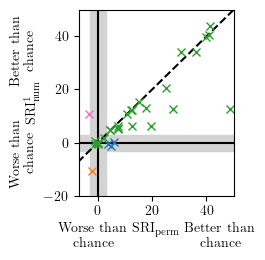

In [11]:
method_1 = r"SRI$_\text{perm}$"
method_2 = r"SRI$_\text{num}^1$"

fig, ax = plt.subplots(figsize=figsizes["half_width_square"])

ax.axvline(0.0, color="black")
ax.axhline(0.0, color="black")


x_lim = [data[('value', method_1)].min(), data[('value', method_1)].max()]
y_lim = [data[('value', method_2)].min(), data[('value', method_2)].max()]

x_lim = [-7, 50]
y_lim = [-20, 50]

ax.fill_between(x_lim, -nsigma, nsigma, color="lightgrey", alpha=1)
ax.fill_between([-nsigma, nsigma], y_lim[0],
                y_lim[1], color="lightgrey", alpha=1)

categories = sorted(data[("category", method_2)].unique())


for category, color in zip(categories, ["tab:orange", "tab:pink", "tab:green", "tab:blue"]):
    df_selected = data[data[("category", method_2)] == category].copy(deep=True)
    if len(df_selected) == 0:
        continue
    # if category != "same":
    #     print(df_selected[[("value", method_1), ("value", method_2)]])

    xerr = [
        df_selected["value"][method_1]
        - df_selected["confidence_low"][method_1],
        df_selected["confidence_high"][method_1]
        - df_selected["value"][method_1],
    ]

    yerr = [
        df_selected["value"][method_2]
        - df_selected["confidence_low"][method_2],
        df_selected["confidence_high"][method_2]
        - df_selected["value"][method_2],
    ]

    # ax.scatter(
    #     df_selected["value"][model_1_str],
    #     df_selected["value"][model_2_str],
    #     color=color,
    #     marker=marker,
    #     s=size,
    #     zorder=10,
    # )
    ax.errorbar(
        df_selected["value"][method_1],
        df_selected["value"][method_2],
        xerr=xerr,
        yerr=yerr,
        fmt='x',
        color=color,
    )

ax.set_aspect("equal")
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
xy_min, xy_max = min(x_min, y_min), max(x_max, y_max)
ax.set_xlim([xy_min, xy_max])
ax.set_ylim([xy_min, xy_max])

ax.plot(
    [xy_min, xy_max],
    [xy_min, xy_max],
    color="black",
    linestyle="dashed",
)
ax.set_aspect("auto")

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.set_xlabel(method_1)
ax.set_ylabel(method_2)

# Annotations for x-axis on the left and right outside the plot area
ax.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)
ax.annotate(
    "Better than\nchance",
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)

# Annotations for y-axis on the top and bottom outside the plot area
ax.annotate(
    "Better than\nchance",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-40, -30),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)
ax.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(-40, 30),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)

# # Add labels I, II, III, IV to the quadrants
# ax.text(0.98, 0.95, r"\textbf{I}", ha="right",
#         va="center", transform=ax.transAxes)
# ax.text(0.02, 0.95, r"\textbf{II}", ha="left",
#         va="center", transform=ax.transAxes)
# ax.text(0.02, 0.05, r"\textbf{III}", ha="left",
#         va="center", transform=ax.transAxes)
# ax.text(0.98, 0.05, r"\textbf{IV}", ha="right",
#         va="center", transform=ax.transAxes)

plt.tight_layout()
plt.savefig(f"./results/SRI_perm_vs_num1.pdf")

## Plot Spearman Correlation

In [41]:
one_sided = False

df = pd.read_csv("results/real.csv")
df = df[df["adjustment"].isin(["ADJUSTED", "STANDARDIZED"])]

# Assemble metric names for plotting
df["one_sided"] = (df["random_model_true"] == "PERM") & (
    df["random_model_true"] != df["random_model_pred"])
df["metric_name"] = df.apply(lambda x: f"{'' if ((x['method_family'] == 'RI') and (x['adjustment'] == 'NORMALIZED')) or (
    x['adjustment'] == 'NONE') else x['adjustment'][0]}{x['method_family']}$_\\text{{{x['random_model_pred'].lower()}}}{'^1' if x['one_sided'] else ''}$", axis=1)

df = df[(df['one_sided'] == one_sided) | ((df['random_model_pred'] == "PERM") & (df['random_model_true'] == "PERM"))]

In [42]:
df_pivot = df.pivot(
    columns="metric_name", index=("dataset", "algorithm"), values="value"
)
correlations = df_pivot.corr(method="spearman")

# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - correlations

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method="average")

# Get the order of rows according to the clustering
leaf_order = leaves_list(linkage_matrix)

# Reorder the correlation matrix according to the clustering result
ordered_correlations = correlations.iloc[leaf_order, leaf_order]

ordered_correlations

metric_name,AMI$_\text{all}$,SMI$_\text{all}$,ARI$_\text{all}$,SRI$_\text{all}$,ARI$_\text{num}$,SRI$_\text{num}$,ARI$_\text{perm}$,SRI$_\text{perm}$,SMI$_\text{num}$,SMI$_\text{perm}$,AMI$_\text{num}$,AMI$_\text{perm}$
metric_name,,,,,,,,,,,,
AMI$_\text{all}$,1.000000,0.799844,0.758471,0.711205,0.282921,0.170182,0.654019,0.528610,0.440597,0.471940,0.688019,0.677207
SMI$_\text{all}$,0.799844,1.000000,0.846757,0.887464,0.311516,0.191201,0.329117,0.096642,0.017687,-0.007487,0.324061,0.276407
ARI$_\text{all}$,0.758471,0.846757,1.000000,0.980183,0.594359,0.477002,0.564195,0.338303,0.288672,0.248632,0.513135,0.465955
SRI$_\text{all}$,0.711205,0.887464,0.980183,1.000000,0.539557,0.420336,0.462011,0.221045,0.175498,0.129254,0.410308,0.360064
ARI$_\text{num}$,0.282921,0.311516,0.594359,0.539557,1.000000,0.969417,0.518556,0.384774,0.488518,0.402129,0.450490,0.390333
SRI$_\text{num}$,0.170182,0.191201,0.477002,0.420336,0.969417,1.000000,0.434428,0.337114,0.470547,0.386283,0.371505,0.315046
ARI$_\text{perm}$,0.654019,0.329117,0.564195,0.462011,0.518556,0.434428,1.000000,0.924137,0.781918,0.780579,0.875699,0.896309
SRI$_\text{perm}$,0.528610,0.096642,0.338303,0.221045,0.384774,0.337114,0.924137,1.000000,0.854767,0.884446,0.824316,0.868128
SMI$_\text{num}$,0.440597,0.017687,0.288672,0.175498,0.488518,0.470547,0.781918,0.854767,1.000000,0.970730,0.917119,0.909983


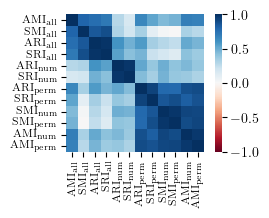

In [43]:
# Plot the correlation matrix
fig, ax = plt.subplots(figsize=figsizes["half_width_square"])
ax = sns.heatmap(ordered_correlations, annot=False,
                 cmap="RdBu", vmin=-1.0, vmax=1.0)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_aspect("equal")

# Use this if ordered_correlations is a DataFrame
labels = ordered_correlations.columns
# If ordered_correlations is not a DataFrame but a numpy array, you might set labels manually
# labels = ['label1', 'label2', 'label3', ...]

# Set x and y ticks
tick_positions = np.arange(0.5, len(labels) + 0.5, 1)
ax.set_xticks(tick_positions)
ax.set_xticklabels(
    labels, rotation=90
)  # Rotate for better orientation if needed

ax.set_yticks(tick_positions)
ax.set_yticklabels(labels)  # Assuming you want labels on y-axis as well

ax.tick_params(axis="x", labelsize=8)  # Adjust x-axis label size
ax.tick_params(axis="y", labelsize=8)  # Adjust y-axis label size
fig.tight_layout()

# Find the colorbar attached to the axis
cbar = ax.collections[0].colorbar

# Adjust the colorbar size
# Here, we're setting the fraction (relative size of the colorbar) and the pad (distance from the heatmap)
cbar.ax.set_aspect(10)
cbar.ax.set_position(
    [ax.get_position().x1 + 0.04, ax.get_position().y0,
     0.03, ax.get_position().height]
)

suffix = "_one_sided" if one_sided else ""

plt.savefig(f"./results/spearman_correlation_heatmap{suffix}.pdf")

## Joint plot

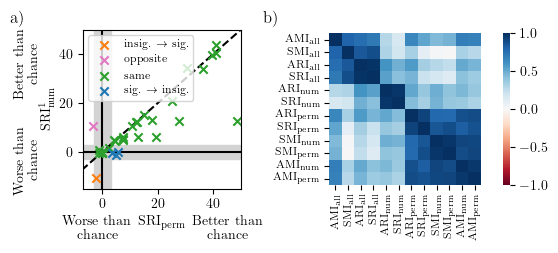

In [56]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(textwidth, textwidth / 2.2), gridspec_kw={"width_ratios": [1, 1.2]}
)

# Figure a)
method_1 = r"SRI$_\text{perm}$"
method_2 = r"SRI$_\text{num}^1$"

ax1.axvline(0.0, color="black", zorder = -1)
ax1.axhline(0.0, color="black", zorder = -1)


x_lim = [data[("value", method_1)].min(), data[("value", method_1)].max()]
y_lim = [data[("value", method_2)].min(), data[("value", method_2)].max()]

x_lim = [-7, 50]
y_lim = [-15, 50]

ax1.fill_between(x_lim, -nsigma, nsigma, color="lightgrey", alpha=1, zorder = -2)
ax1.fill_between([-nsigma, nsigma], y_lim[0], y_lim[1], color="lightgrey", alpha=1, zorder= -2)

categories = sorted(data[("category", method_2)].unique())


for category, color in zip(
    categories, ["tab:orange", "tab:pink", "tab:green", "tab:blue"]
):
    df_selected = data[data[("category", method_2)] == category].copy(deep=True)
    if len(df_selected) == 0:
        continue
    # if category != "same":
    #     print(df_selected[[("value", method_1), ("value", method_2)]])

    xerr = [
        df_selected["value"][method_1] - df_selected["confidence_low"][method_1],
        df_selected["confidence_high"][method_1] - df_selected["value"][method_1],
    ]

    yerr = [
        df_selected["value"][method_2] - df_selected["confidence_low"][method_2],
        df_selected["confidence_high"][method_2] - df_selected["value"][method_2],
    ]

    ax1.scatter(
        df_selected["value"][method_1],
        df_selected["value"][method_2],
        color=color,
        marker="x",
        label=category,
    )
    # ax1.errorbar(
    #     df_selected["value"][method_1],
    #     df_selected["value"][method_2],
    #     xerr=xerr,
    #     yerr=yerr,
    #     fmt="x",
    #     color=color,
    #     label=category,
    # )

ax1.set_aspect("equal")
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()
xy_min, xy_max = min(x_min, y_min), max(x_max, y_max)
ax1.set_xlim([xy_min, xy_max])
ax1.set_ylim([xy_min, xy_max])

ax1.plot(
    [xy_min, xy_max],
    [xy_min, xy_max],
    color="black",
    linestyle="dashed",
    zorder=-1
)
ax1.set_aspect("auto")


ax1.legend(loc="upper left", fontsize=8,)

ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)

ax1.set_xlabel(method_1)
ax1.set_ylabel(method_2)

# Annotations for x-axis on the left and right outside the plot area
ax1.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)
ax1.annotate(
    "Better than\nchance",
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-10, -20),
    textcoords="offset points",
    ha="center",
    va="top",
)

# Annotations for y-axis on the top and bottom outside the plot area
ax1.annotate(
    "Better than\nchance",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(-40, -25),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)
ax1.annotate(
    "Worse than\nchance",
    xy=(0, 0),
    xycoords="axes fraction",
    xytext=(-40, 20),
    textcoords="offset points",
    ha="center",
    va="center",
    rotation="vertical",
)


# # Add labels I, II, III, IV to the quadrants
# ax1.text(0.98, 0.95, r"\textbf{I}", ha="right",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.02, 0.95, r"\textbf{II}", ha="left",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.02, 0.05, r"\textbf{III}", ha="left",
#         va="center", transform=ax1.transAxes)
# ax1.text(0.98, 0.05, r"\textbf{IV}", ha="right",
#         va="center", transform=ax1.transAxes)

fig.tight_layout()
# Add the labels
fig.text(0.02, 1.0, "a)", fontsize=12, weight="bold", ha="left", va="top")
fig.text(0.48, 1.0, "b)", fontsize=12, weight="bold", ha="left", va="top")

# Figure b)

# Plot the correlation matrix
ax2 = sns.heatmap(ordered_correlations, annot=False, cmap="RdBu", vmin=-1.0, vmax=1.0)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_aspect("equal")

# Use this if ordered_correlations is a DataFrame
labels = ordered_correlations.columns
# If ordered_correlations is not a DataFrame but a numpy array, you might set labels manually
# labels = ['label1', 'label2', 'label3', ...]

# Set x and y ticks
tick_positions = np.arange(0.5, len(labels) + 0.5, 1)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(labels, rotation=90)  # Rotate for better orientation if needed

ax2.set_yticks(tick_positions)
ax2.set_yticklabels(labels)  # Assuming you want labels on y-axis as well

ax2.tick_params(axis="x", labelsize=8)  # Adjust x-axis label size
ax2.tick_params(axis="y", labelsize=8)  # Adjust y-axis label size
fig.tight_layout()

# Find the colorbar attached to the axis
cbar = ax2.collections[0].colorbar

# Adjust the colorbar size
# Here, we're setting the fraction (relative size of the colorbar) and the pad (distance from the heatmap)
cbar.ax.set_aspect('auto')
cbar.ax.set_position(
    [
        ax2.get_position().x1 + 0.04,
        ax2.get_position().y0,
        0.03,
        ax2.get_position().height,
    ]
)

fig.savefig("./results/mcpdesouto.pdf")